Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

Acquire datasets

In [4]:
path_to_training_directories = r".\fruit360\fruits-360-original-size\fruits-360-original-size\Training"
path_to_test_images = r".\fruit360\fruits-360-original-size\fruits-360-original-size\Test"

batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  path_to_training_directories,
  seed=123,
  batch_size=batch_size)
class_names = train_ds.class_names
print(class_names)
val_ds = tf.keras.utils.image_dataset_from_directory(
  r".\fruit360\fruits-360-original-size\fruits-360-original-size\Validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 6231 files belonging to 24 classes.
['apple_6', 'apple_braeburn_1', 'apple_crimson_snow_1', 'apple_golden_1', 'apple_golden_2', 'apple_golden_3', 'apple_granny_smith_1', 'apple_hit_1', 'apple_pink_lady_1', 'apple_red_1', 'apple_red_2', 'apple_red_3', 'apple_red_delicios_1', 'apple_red_yellow_1', 'apple_rotten_1', 'cabbage_white_1', 'carrot_1', 'cucumber_1', 'cucumber_3', 'eggplant_violet_1', 'pear_1', 'pear_3', 'zucchini_1', 'zucchini_dark_1']
Found 3114 files belonging to 24 classes.


Let’s test the tutorial model from tensorflow keras site.
First we have to construct it


In [5]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Then compile it

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Let's see the summary

In [6]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

Now we can run it

In [9]:
epochs=4
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/4
195/195 [==============================] - 88s 438ms/step - loss: 0.6434 - accuracy: 0.8126 - val_loss: 0.0969 - val_accuracy: 0.9695
Epoch 2/4
195/195 [==============================] - 82s 424ms/step - loss: 0.0273 - accuracy: 0.9912 - val_loss: 6.8223e-04 - val_accuracy: 1.0000
Epoch 3/4
195/195 [==============================] - 82s 420ms/step - loss: 4.4758e-04 - accuracy: 1.0000 - val_loss: 2.5450e-04 - val_accuracy: 1.0000
Epoch 4/4
195/195 [==============================] - 81s 417ms/step - loss: 1.9298e-04 - accuracy: 1.0000 - val_loss: 1.3936e-04 - val_accuracy: 1.0000


That took a long time (5m 33.9s), but the accuracy seems high, let's plot them to get a better look.

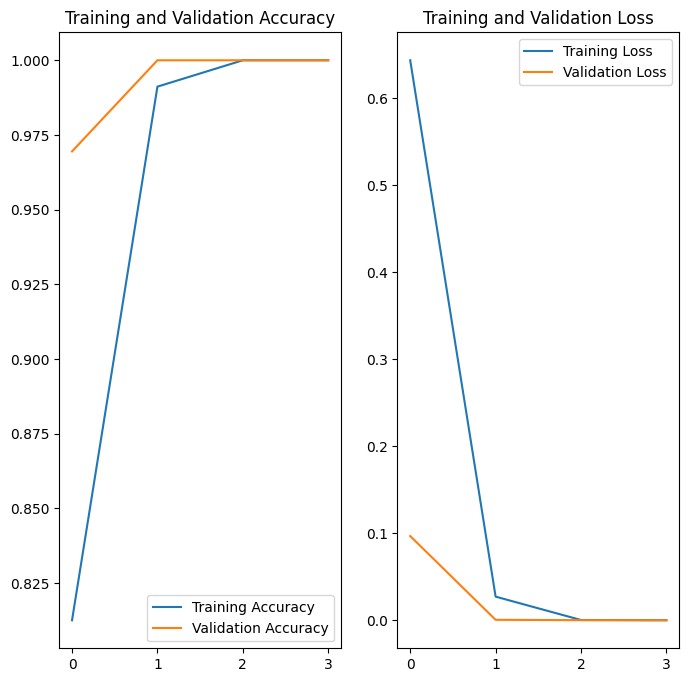

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

100% accuracy, but why is validation accuracy higher than training accuracy, and validation loss lower than training loss?
After some research, (consulting of stack overflow and quora) there could be a few reasons for this
	Sources: https://stackoverflow.com/questions/43979449/higher-validation-accuracy-than-training-accurracy-using-tensorflow-and-keras 

Dropout
    Used during training and not during validation, and makes training worse
    Counter, we didn’t use this
Image leak
    Images from training are being used in validation
    This isn’t happening in a well known package such as keras

However, what could simulate image leak is that the images in validation are just super similar to the images in the training dataset. This leads to our hypothesis that this problem is just very easy for the network to solve.

To test this hypothesis, let’s run some simpler models to see if it can get these seemingly impossible results.

For example, let's run a model with only one CNN layer


In [40]:
num_classes = len(class_names)

oneCNNmodel = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(num_classes)
])

oneCNNmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
oneCNNmodel.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 262144)            0         
                                                                 
 dense_17 (Dense)            (None, 24)                6291480   
                                                                 
Total params: 6,291,928
Trainable params: 6,291,928
Non-trainable params: 0
___________________________________________

In [41]:
epochs=4
history = oneCNNmodel.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/4
195/195 [==============================] - 40s 207ms/step - loss: 3.9453 - accuracy: 0.8058 - val_loss: 0.0378 - val_accuracy: 0.9933
Epoch 2/4
195/195 [==============================] - 40s 206ms/step - loss: 0.0137 - accuracy: 0.9984 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 3/4
195/195 [==============================] - 40s 206ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/4
195/195 [==============================] - 40s 207ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 8.9128e-04 - val_accuracy: 1.0000


That took less time (2m 41.1s), but there's a worrying trend. Let's look at the plots to confirm.

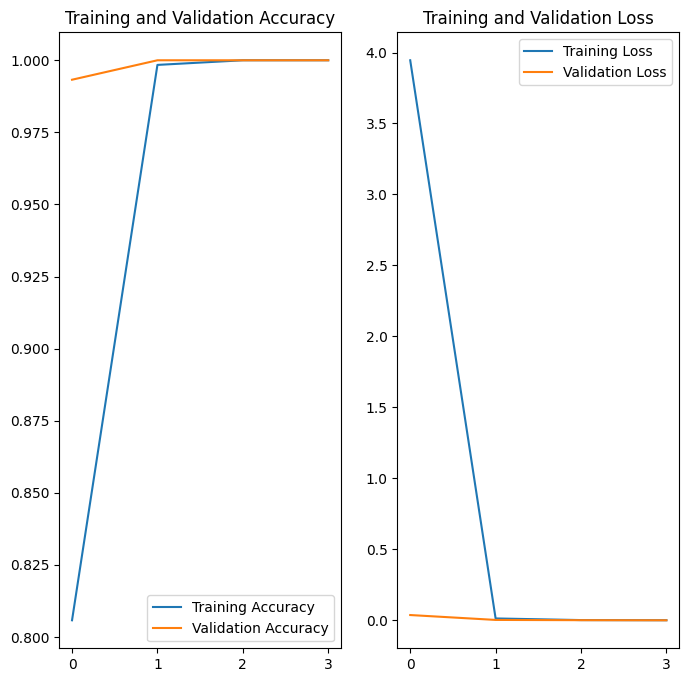

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Wow we have the same issue pointed out durign our presentation. Validation accuracy higher than training.
Weirdly, my research led me to twitter: https://twitter.com/aureliengeron/status/1110839223878184960
It could have something to do with that the validaton is tested 1/2 of an epoch after the training, but I still don't think this is the issue.
It's probably that this problem is too easy.
Let's do one final test for this hypothesis. Just a plain fully connected neural network, no CNN at all.

In [43]:
num_classes = len(class_names)

denseNN = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Flatten(),
  layers.Dense(num_classes)
])

denseNN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
denseNN.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 flatten_16 (Flatten)        (None, 196608)            0         
                                                                 
 dense_18 (Dense)            (None, 24)                4718616   
                                                                 
Total params: 4,718,616
Trainable params: 4,718,616
Non-trainable params: 0
_________________________________________________________________


In [48]:
epochs=18
history = denseNN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/18
195/195 [==============================] - 4s 21ms/step - loss: 35.3395 - accuracy: 0.6176 - val_loss: 2.4790 - val_accuracy: 0.8783
Epoch 2/18
195/195 [==============================] - 4s 22ms/step - loss: 2.0638 - accuracy: 0.8893 - val_loss: 2.3833 - val_accuracy: 0.9098
Epoch 3/18
195/195 [==============================] - 5s 24ms/step - loss: 3.1651 - accuracy: 0.8864 - val_loss: 1.2465 - val_accuracy: 0.8950
Epoch 4/18
195/195 [==============================] - 4s 21ms/step - loss: 2.4558 - accuracy: 0.9257 - val_loss: 10.3081 - val_accuracy: 0.7781
Epoch 5/18
195/195 [==============================] - 4s 20ms/step - loss: 3.1956 - accuracy: 0.9114 - val_loss: 0.7584 - val_accuracy: 0.9557
Epoch 6/18
195/195 [==============================] - 4s 22ms/step - loss: 0.1325 - accuracy: 0.9889 - val_loss: 0.2913 - val_accuracy: 0.9769
Epoch 7/18
195/195 [==============================] - 4s 22ms/step - loss: 2.6679 - accuracy: 0.9127 - val_loss: 4.2417 - val_accuracy: 0.91

Although it takes more epochs, we can still achieve 100% training and validation accuracy.
But do we still see the validation > training anomaly?

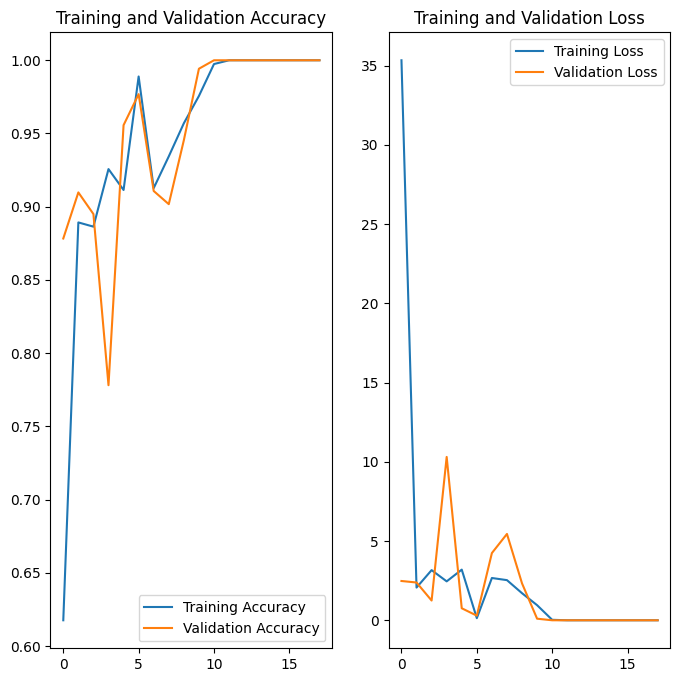

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

So another reason people cited for validation sometimes performing better than training is if the validation set is too small.
In our case, the validation set was seperate and we did not split the data ourselves. In fact, the validation set is about half the size of the training set, so we don't believe this the issue.

Let's see how all three models perform on test data.

In [50]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  path_to_test_images,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
results = model.evaluate(test_ds, batch_size=128)
print("Tutorial model with 3 CNN's and 2 Dense NN's: test loss, test acc:", results)
results = oneCNNmodel.evaluate(test_ds, batch_size=128)
print("Model with 1 CNN and 1 Dense NN: test loss, test acc:", results)
results = denseNN.evaluate(test_ds, batch_size=128)
print("1 Dense NN Model : test loss, test acc:", results)

Found 3110 files belonging to 24 classes.
98/98 [==============================] - 9s 93ms/step - loss: 1.3554e-04 - accuracy: 1.0000
Tutorial model with 3 CNN's and 2 Dense NN's: test loss, test acc: [0.000135544512886554, 1.0]
98/98 [==============================] - 6s 61ms/step - loss: 9.0204e-04 - accuracy: 1.0000
Model with 1 CNN and 1 Dense NN: test loss, test acc: [0.0009020409197546542, 1.0]
98/98 [==============================] - 2s 16ms/step - loss: 4.5574e-08 - accuracy: 1.0000
1 Dense NN Model : test loss, test acc: [4.557389488013541e-08, 1.0]


All 3 models achieved 100% accuracy, and the only difference was the number of epochs it took to train.
Our conclusion is that this is an easy task for neural networks, so we will use the number of epochs as a way to judge the effectiveness of tweaking hyperparameters in our models.

So let's try a network with one CNN layer but with a different activation function to compare.

In [51]:
oneCNNmodelSigmoid = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(num_classes)
])

oneCNNmodelSigmoid.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
oneCNNmodelSigmoid.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 262144)            0         
                                                                 
 dense_20 (Dense)            (None, 24)                6291480   
                                                                 
Total params: 6,291,928
Trainable params: 6,291,928
Non-trainable params: 0
___________________________________________

In [52]:
epochs=10
history = oneCNNmodelSigmoid.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
195/195 [==============================] - 44s 225ms/step - loss: 85.1649 - accuracy: 0.2696 - val_loss: 1.9925 - val_accuracy: 0.6082
Epoch 2/10
195/195 [==============================] - 44s 226ms/step - loss: 2.6711 - accuracy: 0.6466 - val_loss: 2.8921 - val_accuracy: 0.6599
Epoch 3/10
195/195 [==============================] - 44s 225ms/step - loss: 1.6803 - accuracy: 0.7593 - val_loss: 2.4335 - val_accuracy: 0.8234
Epoch 4/10
195/195 [==============================] - 44s 226ms/step - loss: 1.3157 - accuracy: 0.8186 - val_loss: 0.5476 - val_accuracy: 0.8513
Epoch 5/10
195/195 [==============================] - 44s 225ms/step - loss: 0.6971 - accuracy: 0.8832 - val_loss: 0.3294 - val_accuracy: 0.9204
Epoch 6/10
195/195 [==============================] - 44s 225ms/step - loss: 0.8125 - accuracy: 0.8827 - val_loss: 0.2002 - val_accuracy: 0.9560
Epoch 7/10
195/195 [==============================] - 44s 225ms/step - loss: 0.3333 - accuracy: 0.9459 - val_loss: 0.4959 - val_a

This took (7m 20s). As expected, ReLU is much faster comptuationally, and it seems that the sigmoid could not reach the expected 100% accuracy. This is also expected because the main argument for ReLU over sigmoid is that ReLU avoids the vanishing gradient problem. 

We can run this model for a few more epochs to see, but we are expecting that the accuracy will not go up that much as the gradient may have vanished, so the internal weights are not updating by much anymore.

In [53]:
epochs=10
history2 = oneCNNmodelSigmoid.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
195/195 [==============================] - 44s 225ms/step - loss: 0.3809 - accuracy: 0.9480 - val_loss: 0.3086 - val_accuracy: 0.9380
Epoch 2/10
195/195 [==============================] - 44s 225ms/step - loss: 0.0886 - accuracy: 0.9841 - val_loss: 3.3552e-04 - val_accuracy: 1.0000
Epoch 3/10
195/195 [==============================] - 44s 226ms/step - loss: 0.0057 - accuracy: 0.9994 - val_loss: 8.0966e-05 - val_accuracy: 1.0000
Epoch 4/10
195/195 [==============================] - 44s 225ms/step - loss: 0.0261 - accuracy: 0.9973 - val_loss: 7.7770e-05 - val_accuracy: 1.0000
Epoch 5/10
195/195 [==============================] - 44s 227ms/step - loss: 0.2320 - accuracy: 0.9852 - val_loss: 0.9320 - val_accuracy: 0.8927
Epoch 6/10
195/195 [==============================] - 44s 226ms/step - loss: 0.8674 - accuracy: 0.9140 - val_loss: 1.0456 - val_accuracy: 0.8606
Epoch 7/10
195/195 [==============================] - 44s 225ms/step - loss: 0.5202 - accuracy: 0.9499 - val_loss: 0.1

This took (7m 20s). If we plot this on graphs combined with the first 2 epochs, we'll see some very interesting behavior

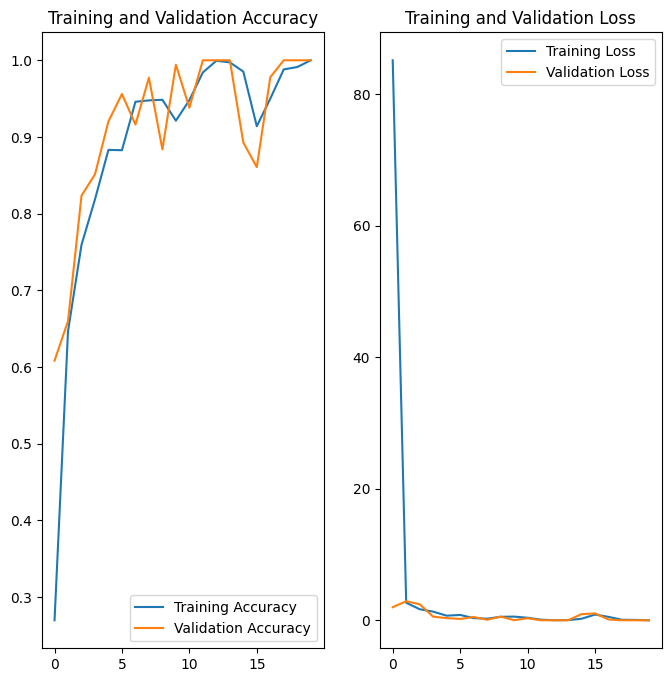

In [54]:
acc = history.history['accuracy'] + history2.history['accuracy']
val_acc = history.history['val_accuracy'] + history2.history['val_accuracy']

loss = history.history['loss'] + history2.history['loss']
val_loss = history.history['val_loss'] + history2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

There are a few epochs (12-14) in which validation accuracy hit 100% but then it dipped back down and then reached 100% again later on. (NO IDEA WHY THIS HAPPENS)
As for training accuracy, it hit 100% after the full 20 epochs.

Usually, 100% training accuracy raises concerns of overfitting, but the track record of all previous models hitting 100% training, validation, and test accuracy dispels these concerns.

Let's test this model.

In [56]:
results = oneCNNmodelSigmoid.evaluate(test_ds, batch_size=128)
print("1 CNN Sigmoid Activaion Function model: test loss, test acc:", results)

98/98 [==============================] - 6s 66ms/step - loss: 6.7692e-05 - accuracy: 1.0000
1 CNN Sigmoid Activaion Function model: test loss, test acc: [6.769162428099662e-05, 1.0]


Again, we hit 100% accuracy, but the main takeaways here is as expected, sigmoid takes longer to run per epoch, and also seems worse than ReLU due to the vanishing gradient problem, even though our NN is not particularly deep, only a few layers.

What about softmax?

In [58]:
oneCNNmodelSoftmax = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='softmax'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(num_classes)
])

oneCNNmodelSoftmax.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
oneCNNmodelSoftmax.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_19 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 262144)            0         
                                                                 
 dense_21 (Dense)            (None, 24)                6291480   
                                                                 
Total params: 6,291,928
Trainable params: 6,291,928
Non-trainable params: 0
___________________________________________

In [59]:
epochs=10
history2 = oneCNNmodelSoftmax.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
195/195 [==============================] - 59s 301ms/step - loss: 8.0228 - accuracy: 0.4474 - val_loss: 0.5239 - val_accuracy: 0.8417
Epoch 2/10
195/195 [==============================] - 58s 300ms/step - loss: 0.3999 - accuracy: 0.8809 - val_loss: 0.3038 - val_accuracy: 0.8992
Epoch 3/10
195/195 [==============================] - 59s 303ms/step - loss: 0.2565 - accuracy: 0.9215 - val_loss: 0.0390 - val_accuracy: 0.9917
Epoch 4/10
195/195 [==============================] - 59s 304ms/step - loss: 0.4169 - accuracy: 0.9037 - val_loss: 0.0381 - val_accuracy: 0.9878
Epoch 5/10
195/195 [==============================] - 60s 307ms/step - loss: 0.0695 - accuracy: 0.9795 - val_loss: 0.0067 - val_accuracy: 0.9984
Epoch 6/10
195/195 [==============================] - 59s 302ms/step - loss: 0.0974 - accuracy: 0.9753 - val_loss: 0.9641 - val_accuracy: 0.9123
Epoch 7/10
195/195 [==============================] - 59s 302ms/step - loss: 0.1833 - accuracy: 0.9618 - val_loss: 0.6531 - val_ac

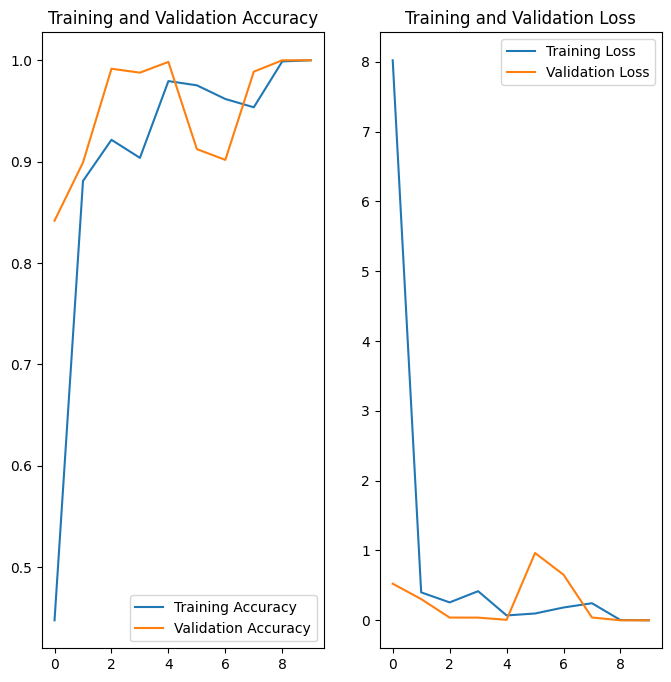

In [61]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [71]:
results = oneCNNmodelSoftmax.evaluate(test_ds, batch_size=128)
print("1 CNN Softmax Activaion Function model: test loss, test acc:", results)

98/98 [==============================] - 6s 61ms/step - loss: 0.6823 - accuracy: 0.7958
1 CNN Softmax Activaion Function model: test loss, test acc: [0.6823172569274902, 0.7958199381828308]


Training each epoch took 1 minute, for a total of 10 minutes total. Softmax is the slowest to train per epoch, but reached 100% training and validation accuracy faster than sigmoid. However, it's testing accuracy did not hit 100%, which leads us to believe it actually overfit.

The last function we wanted to test was Tanh

In [66]:
oneCNNmodelTanh = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(num_classes)
])

oneCNNmodelTanh.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
epochs=4
history2 = oneCNNmodelTanh.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/4
195/195 [==============================] - 43s 218ms/step - loss: 4.0354 - accuracy: 0.8374 - val_loss: 0.0111 - val_accuracy: 1.0000
Epoch 2/4
195/195 [==============================] - 43s 221ms/step - loss: 0.0087 - accuracy: 0.9989 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 3/4
195/195 [==============================] - 43s 218ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 4/4
195/195 [==============================] - 42s 218ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000


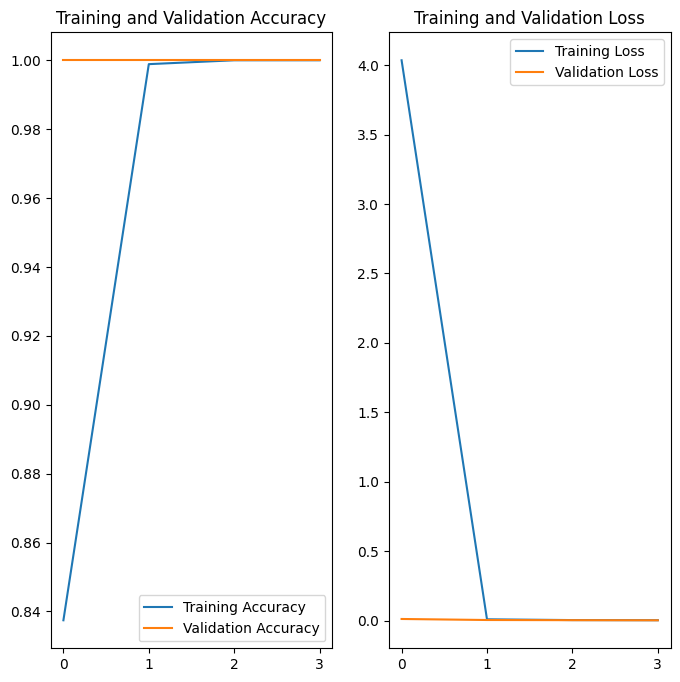

In [67]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
results = oneCNNmodelTanh.evaluate(test_ds, batch_size=128)
print("1 CNN TanH Activaion Function model: test loss, test acc:", results)

98/98 [==============================] - 6s 62ms/step - loss: 0.0017 - accuracy: 1.0000
1 CNN TanH Activaion Function model: test loss, test acc: [0.0017495382344350219, 1.0]


Each epoch was 3s slower to run than ReLU, but the accuracies are similar to ReLU. I think this is due to the problem being easy, and not being complex enough to show the differences between the activation functions.
 
A conclusion we can make is ReLU > Tanh > Sigmoid > Softmax for our purposes.
ReLU ran the fastest for correct results followed by TanH for a close second. Sigmoid took the largest amount of epochs to produce correct results and Softmax was the worst of all worlds. Took the most time per epoch and overfit, not producing 100% accuracy on the test data.

However, this is using softmax as activation function the internal neurons when really, Softmax should be used as the final layer.

In [81]:
num_classes = len(class_names)

oneCNNmodelSoftmaxLastLayer = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(num_classes),
  layers.Activation('softmax')
])

oneCNNmodelSoftmaxLastLayer.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])
              
epochs=4
history = oneCNNmodelSoftmaxLastLayer.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/4
195/195 [==============================] - 40s 206ms/step - loss: 5.4257 - accuracy: 0.8073 - val_loss: 0.0172 - val_accuracy: 1.0000
Epoch 2/4
195/195 [==============================] - 40s 207ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 9.9097e-04 - val_accuracy: 1.0000
Epoch 3/4
195/195 [==============================] - 40s 205ms/step - loss: 5.1952e-04 - accuracy: 1.0000 - val_loss: 2.8329e-04 - val_accuracy: 1.0000
Epoch 4/4
195/195 [==============================] - 40s 207ms/step - loss: 1.6582e-04 - accuracy: 1.0000 - val_loss: 1.1496e-04 - val_accuracy: 1.0000


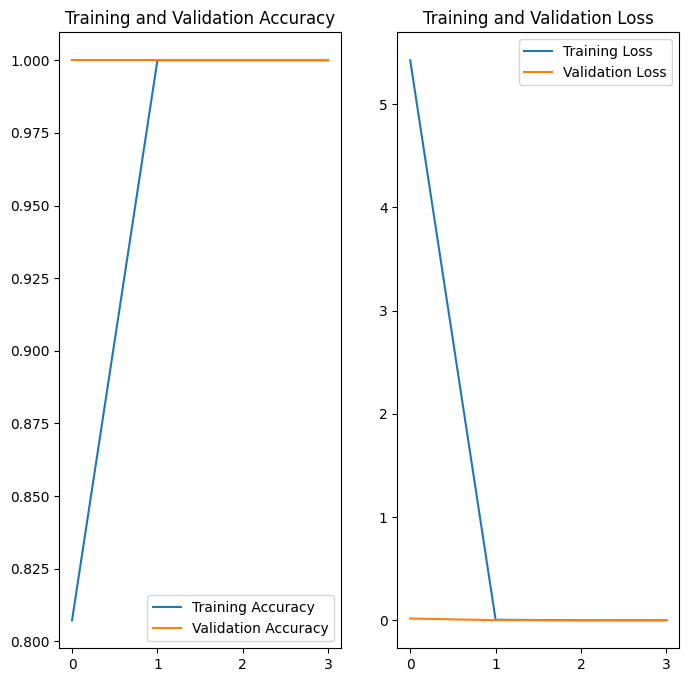

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [86]:
results = oneCNNmodelSoftmaxLastLayer.evaluate(test_ds, batch_size=128)
print("1 CNN ReLU Softmax last layer: test loss, test acc:", results)

98/98 [==============================] - 6s 61ms/step - loss: 1.1704e-04 - accuracy: 1.0000
1 CNN ReLU Softmax last layer: test loss, test acc: [0.00011703643394866958, 1.0]


This was too easy to tell the effectiveness of the softmax. Let's try with just the dense NN

In [89]:
denseNN = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Flatten(),
  layers.Dense(num_classes),
  layers.Activation('softmax')
])

denseNN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
              
epochs=18
history = denseNN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/18
195/195 [==============================] - 4s 21ms/step - loss: 21.5245 - accuracy: 0.6572 - val_loss: 1.5884 - val_accuracy: 0.8622
Epoch 2/18
195/195 [==============================] - 4s 22ms/step - loss: 3.4056 - accuracy: 0.8543 - val_loss: 0.8680 - val_accuracy: 0.9258
Epoch 3/18
195/195 [==============================] - 4s 22ms/step - loss: 3.6604 - accuracy: 0.8828 - val_loss: 0.6956 - val_accuracy: 0.9486
Epoch 4/18
195/195 [==============================] - 4s 22ms/step - loss: 1.3850 - accuracy: 0.9305 - val_loss: 4.8154 - val_accuracy: 0.8719
Epoch 5/18
195/195 [==============================] - 4s 21ms/step - loss: 2.7831 - accuracy: 0.9101 - val_loss: 1.7505 - val_accuracy: 0.9477
Epoch 6/18
195/195 [==============================] - 4s 22ms/step - loss: 1.3164 - accuracy: 0.9480 - val_loss: 0.1320 - val_accuracy: 0.9859
Epoch 7/18
195/195 [==============================] - 4s 22ms/step - loss: 0.4695 - accuracy: 0.9742 - val_loss: 0.5156 - val_accuracy: 0.956

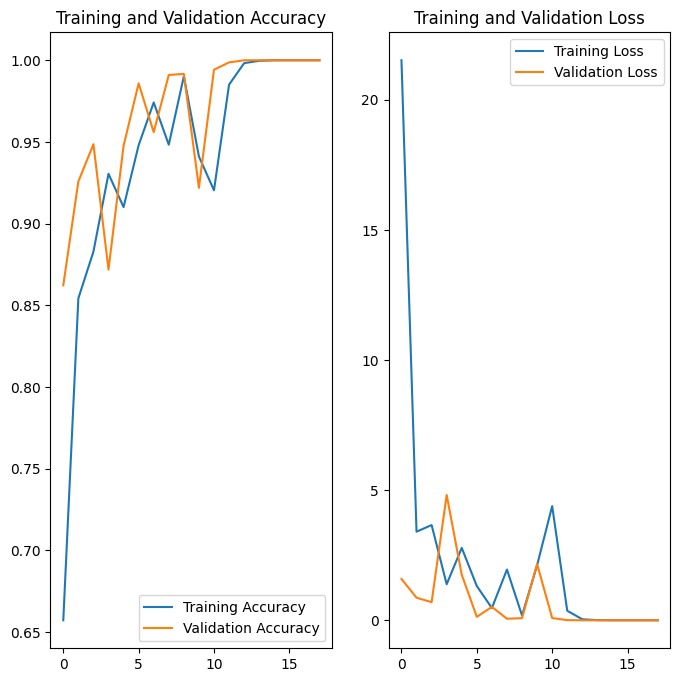

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

With softmax, we've reached 100% accuracy at 13 epochs, which is slower than without. (MAYBE SOME RESEARCH WHY)

In [91]:
results = denseNN.evaluate(test_ds, batch_size=128)
print("Dense NN Softmax last layer: test loss, test acc:", results)

98/98 [==============================] - 2s 16ms/step - loss: 7.6662e-10 - accuracy: 1.0000
Dense NN Softmax last layer: test loss, test acc: [7.666189905108922e-10, 1.0]


But still it's 100% accurate

Conclusion?